# Fouth model: Random forest with TFIDF + complexity features

In [57]:
import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

In [58]:
import time
start = time.time()

import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

import gc

In [5]:
df = pd.read_csv('/home/pipe11/TFM_fake_news_detector/data/corpus_features.csv', index_col = 0)

# Prepare data for the model

## Spanish tokenization

    - Spanish stopwords
    - Stems
    - Tokenizer

In [6]:
#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TF-IDF transformation

In [7]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

### Transformation

In [8]:
df_vectorized = tfidf_vectorizer.fit_transform(df['Text']) 

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Make Dense dataframe Sparse, and Combine with TF-IDF features

In [9]:
# label encoder
labelencoder = LabelEncoder()
df['Labels'] = labelencoder.fit_transform(df['Category'])
y = df['Labels']

# combine TF-IDF features with Dense features as a dataframe Sparse
categorical_features = ['sentences', 'n_words', 'avg_words_sent', 'avg_word_size', 'TTR']

X = hstack([csr_matrix(df[categorical_features].values), df_vectorized[0:]])

gc.collect();

### Split into testing set, training set and validation set

In [10]:
# split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

# Random Forest

## Best parameter grid

In [18]:
param_grid = {
    'bootstrap': True, 
    'max_depth': 95, 
    'max_features': 'auto', 
    'min_samples_leaf': 1, 
    'min_samples_split': 4, 
    'n_estimators': int(1800)
}

In [30]:
model_rf = RandomForestClassifier(bootstrap = True, max_depth = 95, max_features = 'auto', min_samples_leaf = 1, 
                            min_samples_split = 4, n_estimators = 1800)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8366197183098592

## Full model:

In [89]:
df = pd.read_csv('/home/pipe11/TFM_fake_news_detector/data/corpus_spanish.csv', index_col = 0)

# Label encoder
labelencoder = LabelEncoder()
df['Labels'] = labelencoder.fit_transform(df['Category'])
y = df['Labels']

df_text = pd.DataFrame()
df_text['Text'] = text

df = pd.concat([df['Text'], df_text], axis = 0)

########## TFIDF-Vectorizer ##########

tfidf_vectorizer = TfidfVectorizer(  
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords)

df_vectorized = tfidf_vectorizer.fit_transform(df['Text']) 

########## Combine features ##########

# label encoder
labelencoder = LabelEncoder()
df['Labels'] = labelencoder.fit_transform(df['Category'])
y = df['Labels']

# combine TF-IDF features with Dense features as a dataframe Sparse
categorical_features = ['sentences', 'n_words', 'avg_words_sent', 'avg_word_size', 'TTR']

X = hstack([csr_matrix(df[categorical_features].values), df_vectorized[0:]])

gc.collect();

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

########## Model ###########

model_rf = RandomForestClassifier(bootstrap = True, max_depth = 95, max_features = 'auto', min_samples_leaf = 1, 
                        min_samples_split = 4, n_estimators = 1800)

model_rf.fit(X_train, y_train)

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


RandomForestClassifier(max_depth=95, min_samples_split=4, n_estimators=1800)

In [92]:
y_pred = model_rf.predict(X_test)

## Predictions & results

In [93]:
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 83.22%


In [94]:
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
print(cf_matrix)

[[120  30]
 [ 19 123]]


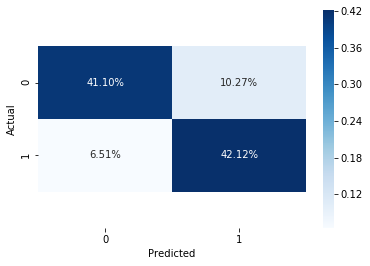

In [95]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Process one new and detect it with the Random Forest model

## Clean text and extract features

In [45]:
def extract_features(df):
    
    n_sentences = []
    n_words = []
    avg_words_sent = []
    avg_word_size = []
    type_token_ratio = []
    
    for i, row in corpus.iterrows():
        text = df['Text'].iloc[i]

        text = text.replace(r"http\S+", "")
        text = text.replace(r"http", "")
        text = text.replace(r"@\S+", "")
        text = text.replace(r"(?<!\n)\n(?!\n)", " ")
        text = text.lower()

        sent_tokens = nltk.sent_tokenize(text)

        #Number of sentences
        number_sentences = len(sent_tokens)

        word_tokens = nltk.word_tokenize(text)

        stop_words = stopwords.words('spanish')
        stop_words.extend(list(punctuation))
        stop_words.extend(['¿', '¡', '"', '``']) 
        stop_words.extend(map(str,range(10)))

        filtered_tokens = [i for i in word_tokens if i not in stop_words]

        #number of tokens
        number_words = len(filtered_tokens)

        # average words per sentence
        avg_word_sentences = (float(number_words)/number_sentences)

        # average word size
        word_size = sum(len(word) for word in filtered_tokens) / number_words

        # type token ratio
        types = nltk.Counter(filtered_tokens)
        TTR = (len(types) / number_words) * 100

        n_sentences.append(number_sentences)
        n_words.append(number_words)
        avg_words_sent.append(avg_word_sentences)
        avg_word_size.append(word_size)
        type_token_ratio.append(TTR)

    df_features['sentences'] = n_sentences
    df_features['n_words'] = n_words
    df_features['avg_words_sent'] = avg_words_sent
    df_features['avg_word_size'] = avg_word_size
    df_features['TTR'] = type_token_ratio
    df_features['Text'] = text

    return df_features

## Pipeline

In [80]:
text = 'Algunos usuarios de Twitter han empezado a compartir hoy vídeos totalmente insólitos, mostrando elefantes paseando despreocupadamente por carreteras, calles y plazas de diversos puntos del territorio español, donde es muy difícil verlos. “Hasta ahora se ocultaban porque sabían que Juan Carlos I estaba al acecho pero ahora han perdido el miedo y se confían porque saben que no está”, explica. Que [el Rey emérito] vuelva cuanto antes porque no se puede caminar por la calle, hay heces por todas partes y solo han pasado unos días desde que se fue su principal depredador”, se queja en Twitter Álvaro Valdés Fernández, un ciudadano de Madrid que ha pisado un inmenso excremento esta mañana y ya habla de una “auténtica plaga de paquidermos”. La mayoría de españoles, sin embargo, cree que las imágenes son curiosas y es bonito ver las calles, antes desiertas, “llenas de vida y elefantes”. El Gobierno considera que los pequeños inconvenientes que los elefantes puedan ocasionar no pasarán a mayores y, de ser así, recuerdan que Felipe VI está “totalmente preparado” para tomar el relevo de su padre en la cadena trófica y sabe utilizar perfectamente a “Poderoso”, el viejo rifle de cazar elefantes del emérito.'

In [81]:
df = pd.read_csv('/home/pipe11/TFM_fake_news_detector/data/corpus_spanish.csv')

# Label encoder
labelencoder = LabelEncoder()
df['Labels'] = labelencoder.fit_transform(df['Category'])
y = df['Labels']

df_text = pd.DataFrame([[text]], columns = ['Text'])

corpus = pd.concat([df['Text'], df_text['Text']], axis = 0)

corpus.reset_index(drop=True, inplace=True)

In [86]:
def extract_features:
        
    df_features = pd.DataFrame()

    n_sentences = []
    n_words = []
    avg_words_sent = []
    avg_word_size = []
    type_token_ratio = []
    list_text = []

    n_corpus = len(corpus)

    for i in range(0, n_corpus):
        text = corpus.iloc[i]

        text = text.replace(r"http\S+", "")
        text = text.replace(r"http", "")
        text = text.replace(r"@\S+", "")
        text = text.replace(r"(?<!\n)\n(?!\n)", " ")
        text = text.lower()

        sent_tokens = nltk.sent_tokenize(text)

        #Number of sentences
        number_sentences = len(sent_tokens)

        word_tokens = nltk.word_tokenize(text)

        stop_words = stopwords.words('spanish')
        stop_words.extend(list(punctuation))
        stop_words.extend(['¿', '¡', '"', '``']) 
        stop_words.extend(map(str,range(10)))

        filtered_tokens = [i for i in word_tokens if i not in stop_words]

        #number of tokens
        number_words = len(filtered_tokens)

        # average words per sentence
        avg_word_sentences = (float(number_words)/number_sentences)

        # average word size
        word_size = sum(len(word) for word in filtered_tokens) / number_words

        # type token ratio
        types = nltk.Counter(filtered_tokens)
        TTR = (len(types) / number_words) * 100

        n_sentences.append(number_sentences)
        n_words.append(number_words)
        avg_words_sent.append(avg_word_sentences)
        avg_word_size.append(word_size)
        type_token_ratio.append(TTR)
        list_text.append(text)

    df_features['sentences'] = n_sentences
    df_features['n_words'] = n_words
    df_features['avg_words_sent'] = avg_words_sent
    df_features['avg_word_size'] = avg_word_size
    df_features['TTR'] = type_token_ratio
    df_features['Text'] = list_text

In [49]:
def tfidf_transformer(corpus):

    tfidf_vectorizer = TfidfVectorizer(  
                    analyzer = 'word',
                    tokenizer = tokenize,
                    lowercase = True,
                    stop_words = spanish_stopwords)

    text_vectorized = tfidf_vectorizer.fit_transform(df_text['Text'])

    return text_vectorized

In [47]:
# combine TF-IDF features with Dense features as a dataframe Sparse
def feature_combiner(df_features):

    categorical_features = ['sentences', 'n_words', 'avg_words_sent', 'avg_word_size', 'TTR']

    X = hstack([csr_matrix(df_text[categorical_features].values), text_vectorized[0:]])
    text_predict = hstack([csr_matrix(df_text[categorical_features].values), text_vectorized[0:]])
    
    

    gc.collect();

    return X_text

In [96]:
# def fake_news_detector(text):
df_text = extract_features(text)
text_vectorized = tfidf_transformer(df_text)
X_text = feature_combiner(df_text)
model_rf.predict(X_text)

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


ValueError: Number of features of the model must match the input. Model n_features is 15569 and input n_features is 106 

In [83]:
tfidf_transformer(df_text)

NameError: name 'df_text' is not defined